In [1]:
#DTW calculation

import pandas as pd
import numpy as np
import os
import glob 
import pickle
from math import *
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
# from quatrotate import qv_mult # this routine implements rotation via quaternion multiplication

%matplotlib inline

/home/vicky/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [3]:
def plot_transportation_mod(transportation_mode, df):
    data = df[df['activity'] == transportation_mode][['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']][:8000]
    
    axis = data.plot(subplots = True, figsize =(20, 20), title = transportation_mode)
    
    for ax in axis:
        ax.legend(loc = 'lower left', bbox_to_anchor=(1.0,0.5))


In [4]:
def GaussianFilter(df, window_length):
    df1 = df
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    return df1

In [5]:
def Mean(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]] + df[input_features[1]]  + df[input_features[2]])/3
    
    return df
    
    

In [6]:
   
 
def ComplementaryFilter(accData, gyrData,pitch, roll):
    AS= 8192
    GS= 65.536
    M_PI= 3.14159265359   
    dt= 0.02  # 10 ms sample rate! 

    pitch += (gyrData[0] / GS) * dt   #// Angle around the X-axis
    roll -=  (gyrData[1] / GS) * dt   # // Angle around the Y-axis
 
    forceMagnitudeApprox = abs(accData[0]) + abs(accData[1]) + abs(accData[2])
    
    if (forceMagnitudeApprox > 8192 and forceMagnitudeApprox < 32768):
        pitchAcc = atan(accData[1], accData[2]) * 180 / M_PI
        pitch = pitch * 0.98 + pitchAcc * 0.02
        rollAcc = atan(accData[0], accData[2]) * 180 / M_PI
        roll = roll * 0.98 + rollAcc * 0.02
        
    return pitch, roll
    

In [7]:
def Yaw_Roll_Pitch(df):
    roll  = []
    pitch = []
    yaw   = []
    xx = []
    yy = []
    zz = []
    roll2=0
    pitch2=0
    for i in range(len(df)):
        x = df['AX'][i]
        y = df['AY'][i]
        z = df['AZ'][i]
        
        gx = df['GX'][i]
        gy = df['GY'][i]
        gz = df['GZ'][i]
        
        roll1 = atan((y/z))*57.3
        pitch1= atan((-x/(y*y + z*z)**(1/2)))*57.3
        yaw1  = atan((z/((x*x + z*z)**(1/2))))*57.3
        
#         xxx = atan(x/((y*y + z*z)**(1/2)))*57.3
#         yyy = atan(y/((x*x + z*z)**(1/2)))*57.3
#         zzz = atan(((y*y + x*x)**(1/2))/z)*57.3
        
        roll2, pitch2 = ComplementaryFilter([x,y,z],[gx,gy,gz],roll2, pitch2)
        
        roll.append(roll1)
        pitch.append(pitch1)
        yaw.append(yaw1)
        
        xx.append(roll2)
        yy.append(pitch2)
    
    df['orientX'] = pitch
    df['orientY'] = roll
    df['orientZ'] = yaw
    
    df['xxx'] = xx
    df['yyy'] = yy
    

In [8]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
   
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
        complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
        df[output_features[i]] = complexs
    return df

In [9]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gz = df['GZ'].values[i: i + N_TIME_STEPS]
        gy = df['GY'].values[i: i + N_TIME_STEPS]
    
        label = "ST"
        
        segments.append([gz,gy])
        labels.append(label)
    return segments, labels

In [10]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(20,4))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [11]:
def data_preprocessing(df):
    df['Milliseconds'] =df['Milliseconds']/1000 
    #apply gaussian filter with window size 5
    df = GaussianFilter(df, 5)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    df = Mean(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    df = Mean(df, input_features, output_feature)
    
    Yaw_Roll_Pitch(df)
    
    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    
    return df
    
    
    
    
    

In [12]:
# def graph_plot():
#     x = np.arange(337)
#     y = np.arange(337)
#     plt.figure(figsize=(200,4))
#     fig,ax = plt.subplots(1)

#     ax.plot(x,y)
#     # Get current size
#     fig_size = plt.rcParams["figure.figsize"]

#     # Prints: [8.0, 6.0]
#     print ("Current size:", fig_size)

#     # Set figure width to 12 and height to 9
#     fig_size[0] = 20
#     fig_size[1] = 4
#     plt.rcParams["figure.figsize"] = fig_size
#     plt.plot(x,y)
#     print ("Current size:", fig_size)
#     major_ticks = np.arange(0, 337, 10)
#     minor_ticks = np.arange(0, 337, 5)
#     ax.set_xticks(major_ticks)
#     ax.set_xticks(minor_ticks, minor=True)

#     plt.grid(True)

In [13]:
# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [14]:
def dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r - 1)
                j_k = min(j + k, c - 1)
                min_list += [D0[i_k, j], D0[i, j_k]]
            D1[i, j] += min(min_list)
#     if len(x)==1:
#         path = zeros(len(y)), range(len(y))
#     elif len(y) == 1:
#         path = range(len(x)), zeros(len(x))
#     else:
#         path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1

In [15]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [16]:
def loss_for_segments(segments, comp, dist_fun):
    loss =[]
    length = len(segments)
    for i in range(length):
        x = segments[i][0]
        dist, cost, acc = dtw(x, cmp, dist_fun)
        print(i , '=>', dist)
        loss.append(dist)
        
    return loss
    

In [22]:
#data for bike
acc_file = 'data/Bike2308/2018-08-23_16-18-07/AccelerometerLinear.csv'
gyro_file= 'data/Bike2308/2018-08-23_16-18-07/Gyroscope.csv'

df_bike = read_csv_file(acc_file, gyro_file, 'bike')

n = len(df_bike)
print("shape -", df_bike.shape)

df_bike = df_bike[1000 : n-1000]

df_bike.reset_index(drop = True, inplace = True)
df_bike = data_preprocessing(df_bike)
print("shape -", df_bike.shape)
df_bike.head()

shape - (14413, 8)
shape - (12413, 21)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,...,orientY,orientZ,xxx,yyy,fAX,fAY,fAZ,fGX,fGY,fGZ
0,20.001,-0.344690,0.352213,-0.131941,-0.045794,-0.007894,0.566408,bike,-0.041472,0.170907,...,-69.468969,-19.672707,-0.000014,0.000002,-610.554514,-1338.440613,88.325471,-610.554514,-1338.440613,88.325471
1,20.021,-0.325112,0.353453,-0.125852,-0.045373,-0.007476,0.564057,bike,-0.032503,0.170403,...,-70.406220,-19.851021,-0.000028,0.000005,134.212886,67.370358,40.923363,134.212886,67.370358,40.923363
2,20.041,-0.287051,0.355392,-0.113982,-0.044581,-0.006686,0.559156,bike,-0.015213,0.169296,...,-72.223172,-20.258033,-0.000041,0.000007,-30.141141,-59.956886,-20.362319,-30.141141,-59.956886,-20.362319
3,20.062,-0.232431,0.357122,-0.096918,-0.043502,-0.005623,0.551344,bike,0.009258,0.167406,...,-74.821898,-21.051251,-0.000055,0.000008,155.770975,129.440046,-8.727666,155.770975,129.440046,-8.727666
4,20.081,-0.164102,0.357596,-0.075456,-0.042231,-0.004415,0.540164,bike,0.039346,0.164506,...,-78.090549,-22.675217,-0.000068,0.000010,-217.732865,-192.100957,64.886329,-217.732865,-192.100957,64.886329


In [20]:
#latex table generate
table_df = df_bike[['AX','AY','AZ', 'GX', 'GY','GZ']].head(10)
#print(table_df.to_latex())
latex_file = open("table.tex", "w")
latex_file.write(table_df.to_latex())
latex_file.close()

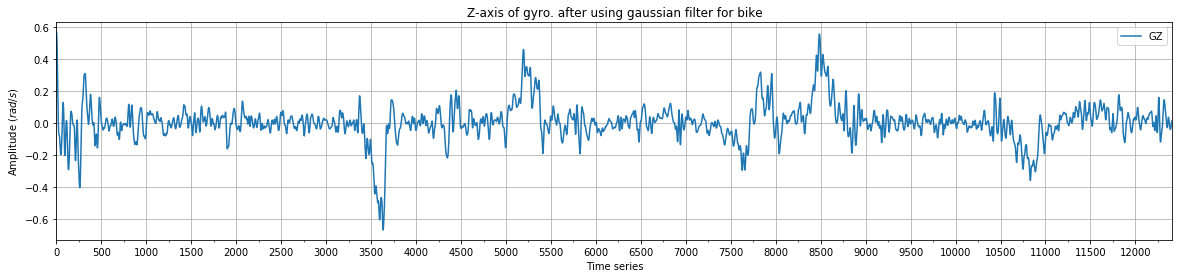

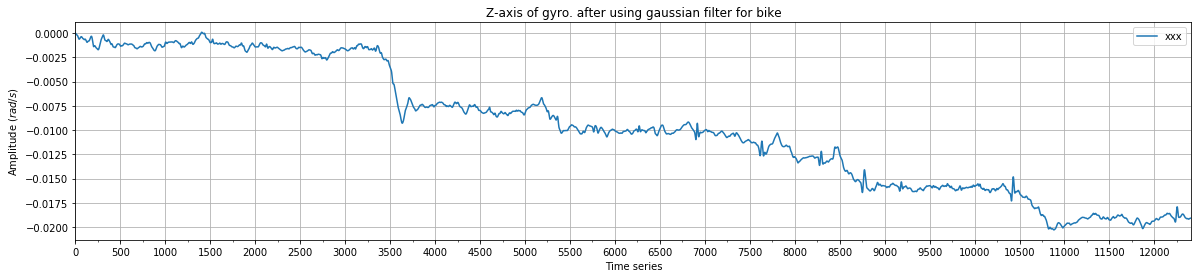

In [18]:
n = len(df_bike)
fig, ax = plt.subplots()
df_bike[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)
fig, ax = plt.subplots()
df_bike[['xxx']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

In [22]:
#data for bike
acc_file = 'data/Bike2308/2018-08-23_16-15-15/AccelerometerLinear.csv'
gyro_file= 'data/Bike2308/2018-08-23_16-15-15/Gyroscope.csv'

df_bike1 = read_csv_file(acc_file, gyro_file, 'bike')

n = len(df_bike1)
print("shape -", df_bike1.shape)

df_bike1 = df_bike1[1000 : n-1000]

df_bike1.reset_index(drop = True, inplace = True)
df_bike1 = data_preprocessing(df_bike1)
print("shape -", df_bike1.shape)
df_bike1.head()



shape - (7601, 8)
shape - (5601, 21)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,...,orientY,orientZ,xxx,yyy,fAX,fAY,fAZ,fGX,fGY,fGZ
0,20.001,0.064721,-0.338482,-0.036086,0.030317,0.000798,-0.028652,bike,-0.103282,0.000821,...,83.920832,-25.967039,0.000009,-2.436288e-07,214.572877,-853.945574,17.673453,214.572877,-853.945574,17.673453
1,20.022,0.063199,-0.340854,-0.035360,0.029147,0.002519,-0.028442,bike,-0.104338,0.001075,...,84.083610,-26.026702,0.000018,-1.012381e-06,6.900917,194.611244,11.728499,6.900917,194.611244,11.728499
2,20.041,0.060563,-0.345927,-0.034363,0.026951,0.005847,-0.028004,bike,-0.106576,0.001598,...,84.333227,-26.267921,0.000026,-2.796677e-06,81.623407,136.747128,42.528071,81.623407,136.747128,42.528071
3,20.061,0.057548,-0.354286,-0.033995,0.023963,0.010540,-0.027313,bike,-0.110244,0.002397,...,84.525222,-26.960562,0.000034,-6.013210e-06,49.650241,-325.385333,65.387126,49.650241,-325.385333,65.387126
4,20.082,0.054883,-0.366660,-0.035180,0.020476,0.016250,-0.026345,bike,-0.115652,0.003460,...,84.525588,-28.355649,0.000040,-1.097237e-05,-245.438437,-28.728289,-83.593948,-245.438437,-28.728289,-83.593948


In [23]:
print("shape -", df_bike.shape)
print("shape -", df_bike1.shape)

df = pd.concat([df_bike, df_bike1])
df.reset_index(drop = True, inplace = True)
n = len(df)
print("shape -", df.shape)
df.head()

shape - (12413, 21)
shape - (5601, 21)
shape - (18014, 21)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,...,orientY,orientZ,xxx,yyy,fAX,fAY,fAZ,fGX,fGY,fGZ
0,20.001,-0.344690,0.352213,-0.131941,-0.045794,-0.007894,0.566408,bike,-0.041472,0.170907,...,-69.468969,-19.672707,-0.000014,0.000002,-610.554514,-1338.440613,88.325471,-610.554514,-1338.440613,88.325471
1,20.021,-0.325112,0.353453,-0.125852,-0.045373,-0.007476,0.564057,bike,-0.032503,0.170403,...,-70.406220,-19.851021,-0.000028,0.000005,134.212886,67.370358,40.923363,134.212886,67.370358,40.923363
2,20.041,-0.287051,0.355392,-0.113982,-0.044581,-0.006686,0.559156,bike,-0.015213,0.169296,...,-72.223172,-20.258033,-0.000041,0.000007,-30.141141,-59.956886,-20.362319,-30.141141,-59.956886,-20.362319
3,20.062,-0.232431,0.357122,-0.096918,-0.043502,-0.005623,0.551344,bike,0.009258,0.167406,...,-74.821898,-21.051251,-0.000055,0.000008,155.770975,129.440046,-8.727666,155.770975,129.440046,-8.727666
4,20.081,-0.164102,0.357596,-0.075456,-0.042231,-0.004415,0.540164,bike,0.039346,0.164506,...,-78.090549,-22.675217,-0.000068,0.000010,-217.732865,-192.100957,64.886329,-217.732865,-192.100957,64.886329


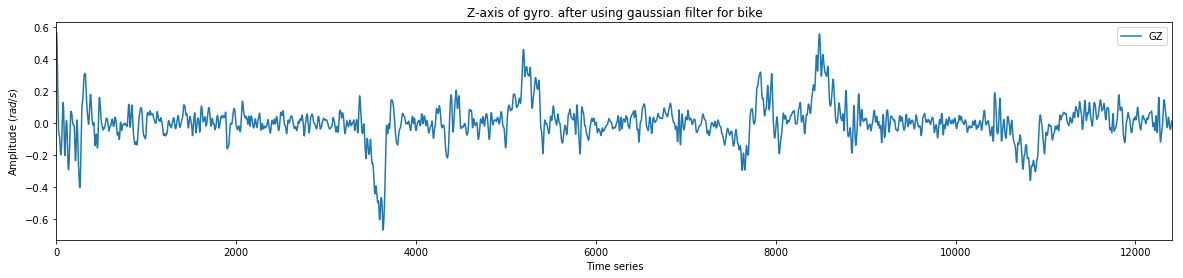

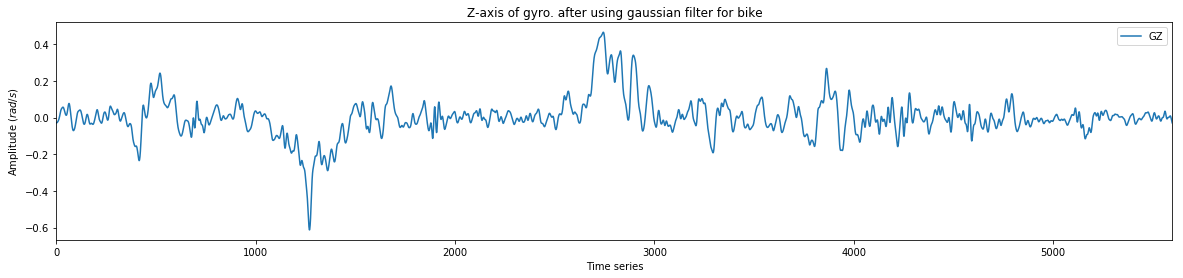

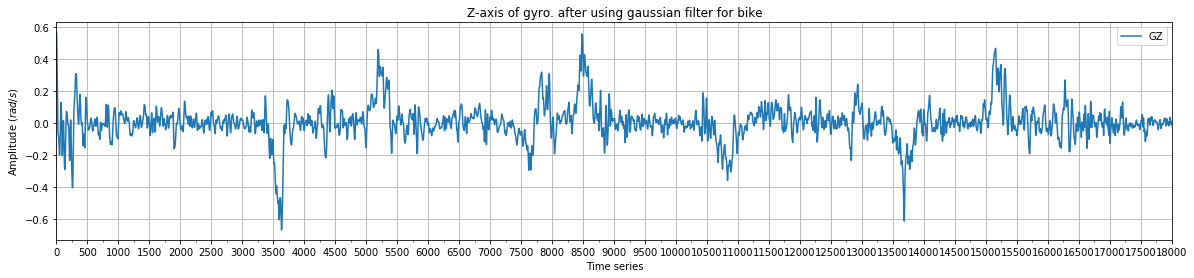

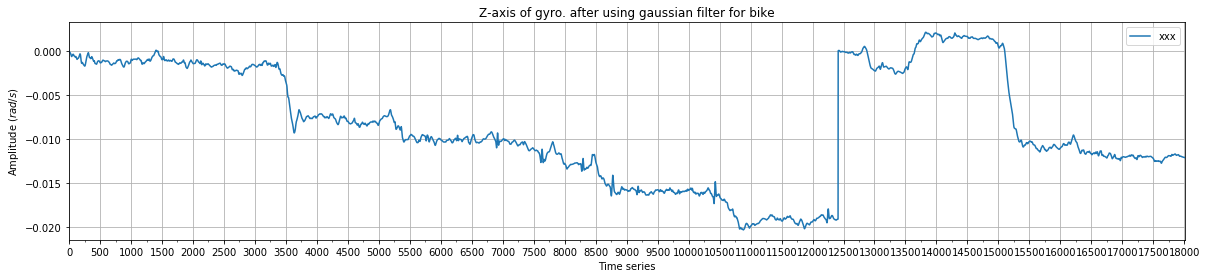

In [25]:
df_bike[['GZ']].plot(figsize = (20,4), title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')

df_bike1[['GZ']].plot(figsize = (20,4), title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')

fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)


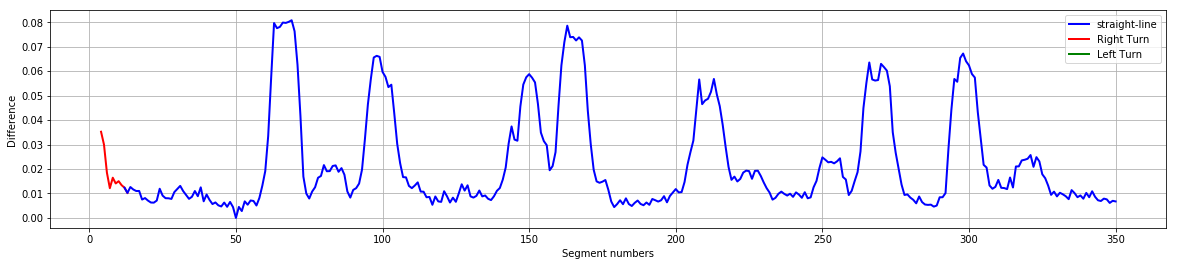

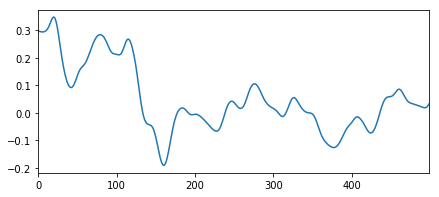

In [24]:
bike_segments, bike_labels = segmentation(df, 500)
np.array(bike_segments).shape
bike_labels[5:13] = ["LT"] * (13-5)
bike_labels[95:105] = ["LT"] * (105-95)
x = bike_segments[105][0]
xx = pd.Series(x)
xx.plot(figsize = (7,3))

In [143]:
dist_fun = manhattan_distances
y = bike_segments[50][0]
diff_wrt_ST_bike = loss_for_segments(bike_segments, y ,dist_fun)
loss_series = pd.Series(diff_wrt_ST_bike)
loss_series.to_csv('diff_wrt_ST_bike')

0 => 0.0465033074544
1 => 0.0396606104051
2 => 0.0362299286839
3 => 0.030272602107
4 => 0.0352241413442
5 => 0.0299647358149
6 => 0.0184891925746
7 => 0.0121507551254
8 => 0.0164371692562
9 => 0.0140881802231
10 => 0.0150142983998
11 => 0.0133946251024
12 => 0.0123516030852
13 => 0.0102163492355
14 => 0.0126279548199
15 => 0.0116131319172
16 => 0.010996201183
17 => 0.011017150747
18 => 0.00750897303769
19 => 0.00811186903506
20 => 0.00708248556545
21 => 0.00629098945563
22 => 0.00624027981306
23 => 0.00709894765497
24 => 0.0119239426527
25 => 0.00910954265763
26 => 0.00806111056366
27 => 0.00802065027542
28 => 0.00776715760458
29 => 0.0105554018797
30 => 0.0118572189733
31 => 0.0130973797238
32 => 0.0109753938562
33 => 0.0093559937163
34 => 0.00779622211973
35 => 0.00864402999317
36 => 0.0109926460008
37 => 0.00887649857967
38 => 0.0124936178162
39 => 0.00679570442582
40 => 0.00956401129682
41 => 0.00735186850934
42 => 0.00566387554211
43 => 0.00633251547523
44 => 0.00514087315619
45 =

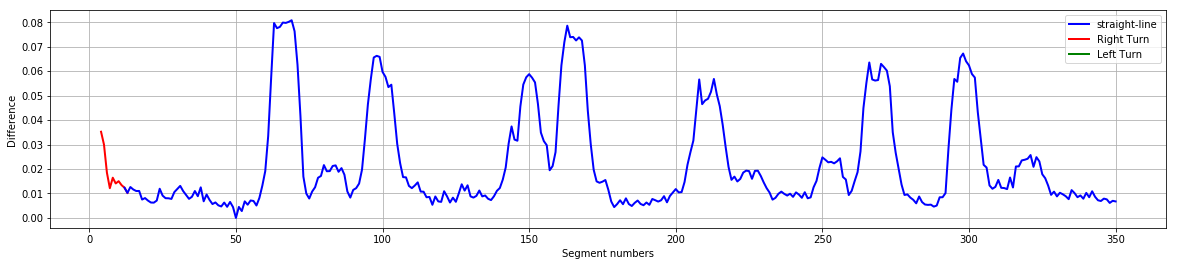

In [147]:
bike_colors = pltcolor(bike_labels)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series
x = np.arange(len(y))
plot_multicolored_lines(x,y,bike_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')

plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()


In [155]:
dist_fun = manhattan_distances
y = bike_segments[67][0]
diff_wrt_LT_bike = loss_for_segments(bike_segments, y ,dist_fun)
loss_series_LT = pd.Series(diff_wrt_LT_bike)
loss_series_LT.to_csv('diff_wrt_LT_bike')

0 => 0.0452540438192
1 => 0.0378826838662
2 => 0.0374805982193
3 => 0.0323626582233
4 => 0.038736546349
5 => 0.0686365693051
6 => 0.0642138070357
7 => 0.0579442095877
8 => 0.0680727667366
9 => 0.0667955567376
10 => 0.0654193559472
11 => 0.0638591690434
12 => 0.0634693392116
13 => 0.0629904134505
14 => 0.0641316665672
15 => 0.0647261063663
16 => 0.0650585628302
17 => 0.0672088749221
18 => 0.070087097995
19 => 0.0723763322651
20 => 0.0751535392413
21 => 0.0748288033895
22 => 0.0752980944068
23 => 0.077322844631
24 => 0.0774742749516
25 => 0.0791710529967
26 => 0.0772523308023
27 => 0.077165584279
28 => 0.078856182915
29 => 0.0725325241361
30 => 0.0662350760158
31 => 0.0630530727846
32 => 0.0624521500583
33 => 0.0621219489995
34 => 0.0628628358903
35 => 0.0608518028795
36 => 0.0610994523496
37 => 0.0611927495991
38 => 0.0726833526949
39 => 0.0798103368933
40 => 0.0806258908496
41 => 0.0817720383142
42 => 0.0805827384571
43 => 0.0802293882818
44 => 0.0808929938936
45 => 0.0809902877664
46 

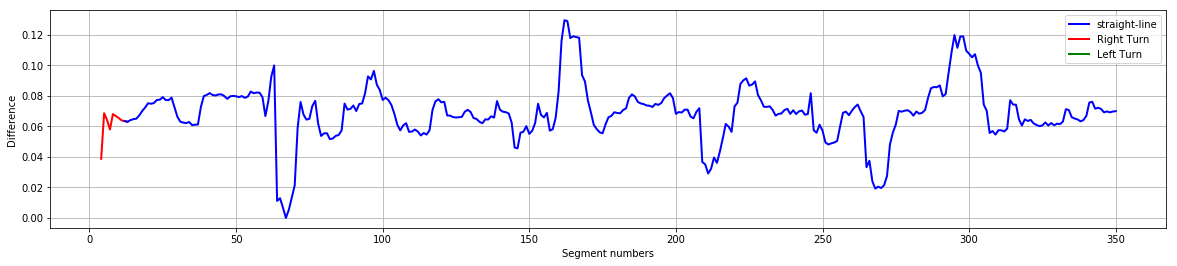

In [156]:
legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series_LT
x = np.arange(len(y))
plot_multicolored_lines(x,y,bike_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')

plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

In [ ]:

dist_fun = manhattan_distances
y = bike_segments[100][0]
diff_wrt_RT_bike = loss_for_segments(bike_segments, y ,dist_fun)
loss_series_RT = pd.Series(diff_wrt_RT_bike)
loss_series_RT.to_csv('diff_wrt_LT_bike')

0 => 0.0535049492916
1 => 0.0420573697782
2 => 0.0383567872327
3 => 0.0342812484138
4 => 0.0300340800523
5 => 0.0256037810288
6 => 0.0384885895645
7 => 0.0362818734628
8 => 0.0428391712854
9 => 0.039763222882
10 => 0.0485188792267
11 => 0.0480082970729
12 => 0.0475089993274
13 => 0.0466773242147
14 => 0.0472584807912
15 => 0.049620904128
16 => 0.0510635780214
17 => 0.0499046873683
18 => 0.0500447503402
19 => 0.0566387742979
20 => 0.054664078931
21 => 0.0518838883437
22 => 0.0502878282278
23 => 0.0481131545159
24 => 0.0467488710231
25 => 0.0484885637453
26 => 0.0487070509463
27 => 0.0487014369426
28 => 0.050534188814
29 => 0.0530597006653
30 => 0.0516165336086
31 => 0.050193758457
32 => 0.0505590617433
33 => 0.0522187294818
34 => 0.0526612384931
35 => 0.0504587078958
36 => 0.0505695477079
37 => 0.0488154533284
38 => 0.0423761636983
39 => 0.04296735896
40 => 0.0402307016608
41 => 0.041321656191
42 => 0.0606730901522
43 => 0.0591859491328
44 => 0.0573252225288
45 => 0.0564620637496
46 => 